# Project - Predictability for Correlation

In [1]:
import numpy as np
import pandas as pd 
import math
from random import gauss
from math import sqrt
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from math import log, sqrt, exp
from scipy.stats import norm
from glob import glob
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import warnings
import os
from functools import reduce
warnings.filterwarnings("ignore")

# Data Acquisition and Cleaning - 10 years daily from NASDAQ 100 Technology Sector 

In [2]:
# function for reading files
def read_file(f):
    df = pd.read_csv(f)
    df['ticker'] = f.split('.')[0].strip('^')
    return df

# function for getting log-returns
def getlogret(data):
    logret = np.log(data) - np.log(data.shift(1))
    return logret

In [3]:
# create the dataframe for closing price, named as 'close'
close = pd.concat([read_file(f) for f in glob('*.csv')])
close = close.set_index(['Date','ticker'])[['Close']].unstack()
# extract the tickers for renaming purpose later
tickers = close.columns.get_level_values('ticker')

In [4]:
# create the dataframe for logreturns, named as 'logret'
logret = close
for i in range(0,len(close.axes[1])):
    logret.iloc[:,i] = getlogret(close.iloc[:,i])
logret = logret.iloc[1:].rename(columns={'Close': 'Logret'})
logret = logret.round(20) # make sure the precision in data is not lost throughout the process of predicting

In [5]:
# define df with only stocks
df = logret
df.columns = tickers
ixic = df['IXIC']
# create df 'stock' which includes only the 10 securities
stock = df  
stock = stock.drop(['IXIC', 'NDXT'], axis=1) 
# the df 'stock' will be the data set that the analysis for correlation will be based on

# Data Analysis - use the historical data to predict the future

In [6]:
# Define functions for actual/predicted volatility and the absolute error between them

def corpred(df, index, n): # function for prediction
    # keep the index for non-overlapped rolling window. eg for a=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], a[2::3]=[2, 5, 8]
    return (df.rolling(n).corr(index)[n-1::n]) # change to annualized volatility

def corAPE(df, index, n): # use absolute percentage error
    df_corpred = corpred(df, index, n)
    df_coract = df_corpred.shift(-1)
    df_corerr = (df_corpred - df_coract).iloc[:-1]  # delete the last NaN row
    df_corAMPE = (df_corerr.div(df_coract.iloc[:-1])).abs() # abs((actual-pred)/actual)
    df_corAMPE.columns=pd.MultiIndex.from_product([['APE (Correlation)'], df_corAMPE.columns])
    return df_corAMPE

def corAMPE(df, index, n): # use absolute mean percentage error
    df_corpred = corpred(df, index, n)
    df_coract = df_corpred.shift(-1)
    df_corerr = (df_corpred - df_coract).iloc[:-1]  # delete the last NaN row
    avg = (df_coract.iloc[:-1] + df_corpred.iloc[:-1]) / 2   # exclude the last NaN rows
    df_corAMPE = (df_corerr.div(avg)).abs() # abs((actual-pred)/avg)
    df_corAMPE.columns=pd.MultiIndex.from_product([['AMPE (Correlation)'], df_corAMPE.columns])
    return df_corAMPE

## Iterating through time windows 

In [7]:
# define functions for plotting histogram and the numerical results
# given the error functions and a fixed timewindow
def plothist_cor(function, df, index, tw):
    myerr = function(df, index, tw)
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca()
    errplot = myerr.hist(ax = ax)
    errvalue = print(myerr)
    return errvalue, errplot

# define functions for printing the numerical results and plotting the dot graphs
# given the error functions, starting&ending timewindow with step size, tail
def plotdot_cor(function, index, tw1, tw2, step, tail):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((stock.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with the percentage of error observations greater than tail
    percent = dfnan
    j = 0
    tw_inf = [] # mark the timewindows for which the errors include +/-inf 
    tw_null = [] # mark the timewindows for which the errors include NaN 
    
    for i in range(tw1, tw2+step, step):
        myerr = function(stock, index, i)
        
        # check infinity problem
        if myerr.isin([np.inf, -np.inf]).values.any() == True :
            tw_inf.append(i)
        else :
            tw_inf = tw_inf            
        # check NaN problem
        if myerr.isnull().values.any() == True :
            tw_null.append(i)
        else :
            tw_null = tw_null
            
        # create df 'outlier' consists of T/F, T if abs err>tail
        outlier = myerr > tail
        # fill in values representing the percentage of abs error outside tail
        # outlier.mean() calculates percentage of T values 
        percent.iloc[:,j] = outlier.mean().reset_index(drop=True) 
        j = j+1
    
    percent_T = percent.transpose() # exchange x and y axis for plotting purpose
    percent_T.columns = stock.columns # rename the columns as the securities
    med = percent_T.median(axis=1) # calculate the median of the percentage for each time window size
    avg = percent_T.mean(axis=1) # calculate the average of the percentage for each time window size
    dotvalue = print(percent_T)
    msg_inf = print(f"Inf error exists when time window = {tw_inf}")
    msg_null = print(f"NaN exists when time window = {tw_null}")
    
    # plot the dot chart
    funcname = str(function.__name__)
    dotplot = percent_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Correlation with Nasdaq, Percentage of error observations greater than tail={tail}, {funcname.strip('cor')}")
    dotplot_med = med.plot(ls = '-', marker = 'o', figsize = (10,5), label = "median")
    dotplot_avg = avg.plot(ls = '-', marker = 'o', figsize = (10,5), label = "average")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return msg_inf, msg_null, dotvalue, dotplot, dotplot_med, dotplot_avg

# define function for dot plot of r-squared from regression between actual and prediction
def plotr2_cor(index, tw1, tw2, step):
    
    # create a NaN dataframe with rows as the time window, columns as the securities
    col_names = [i for i in range(tw1, tw2+step, step)] # timewindow
    # generate NaN entries
    data = np.empty((stock.shape[1], len(col_names))) # number of rows = number of securities
    # create dataframe
    data[:] = np.nan
    dfnan = pd.DataFrame(data, columns=col_names)
    
    # fill in the NaN dataframe with r-squared values
    df_r2 = dfnan
    j = 0
    #k = 0
    tw_inf = [] # mark the timewindows for which the errors include +/-inf 
    tw_null = [] # mark the timewindows for which the errors include NaN 
    
    for i in range(tw1, tw2+step, step):
        df_corpred = corpred(stock, index, i)
        df_coract = df_corpred.shift(-1).iloc[:-1]
        df_corpred = df_corpred.iloc[:-1]
        
        for k in range(0, len(stock.columns), 1):
            # reshape the values of x(actual) and y(prediction) to (length,1) to use sklearn
            act = df_coract.iloc[:,k].values.reshape(len(df_coract.iloc[:,k]), 1)
            pred = df_corpred.iloc[:,k].values.reshape(len(df_corpred.iloc[:,k]), 1)
            md = linear_model.LinearRegression()
            md.fit(act, pred)
            r2 = md.score(act, pred)
            # fill in r2 into df_r2
            df_r2.iloc[k,j] = r2
        
        #k = k+1
        j = j+1
        
        # check infinity problem
        if df_corpred.isin([np.inf, -np.inf]).values.any() == True :
            tw_inf.append(i)
        else :
            tw_inf = tw_inf            
        # check NaN problem
        if df_corpred.isnull().values.any() == True :
            tw_null.append(i)
        else :
            tw_null = tw_null

    
    df_r2_T = df_r2.transpose() # exchange x and y axis for plotting purpose
    df_r2_T.columns = stock.columns # rename the columns as the securities
    med = df_r2_T.median(axis=1) # calculate the median of the r2 for each time window size
    avg = df_r2_T.mean(axis=1) # calculate the average of the r2 for each time window size
    dotvalue = print(df_r2)
    msg_inf = print(f"Inf error exists when time window = {tw_inf}")
    msg_null = print(f"NaN exists when time window = {tw_null}")
    
    # plot the dot chart
    #funcname = str(function.__name__)
    dotplot = df_r2_T.plot(ls = '', marker = '.', figsize = (10,5), title = f"Correlation, R-squared from regression between actual and prediction")
    dotplot_med = med.plot(ls = '-', marker = 'o', figsize = (10,5), label = "median")
    dotplot_avg = avg.plot(ls = '-', marker = 'o', figsize = (10,5), label = "average")
    dotplot.legend(bbox_to_anchor = (1.2, 1))
    return msg_inf, msg_null, dotvalue, dotplot, dotplot_med, dotplot_avg

## Compute results for correlation

### Predicted Results

Text(0.5, 0.89, 'Predicted Correlation with Nasdaq Index (IXIC)')

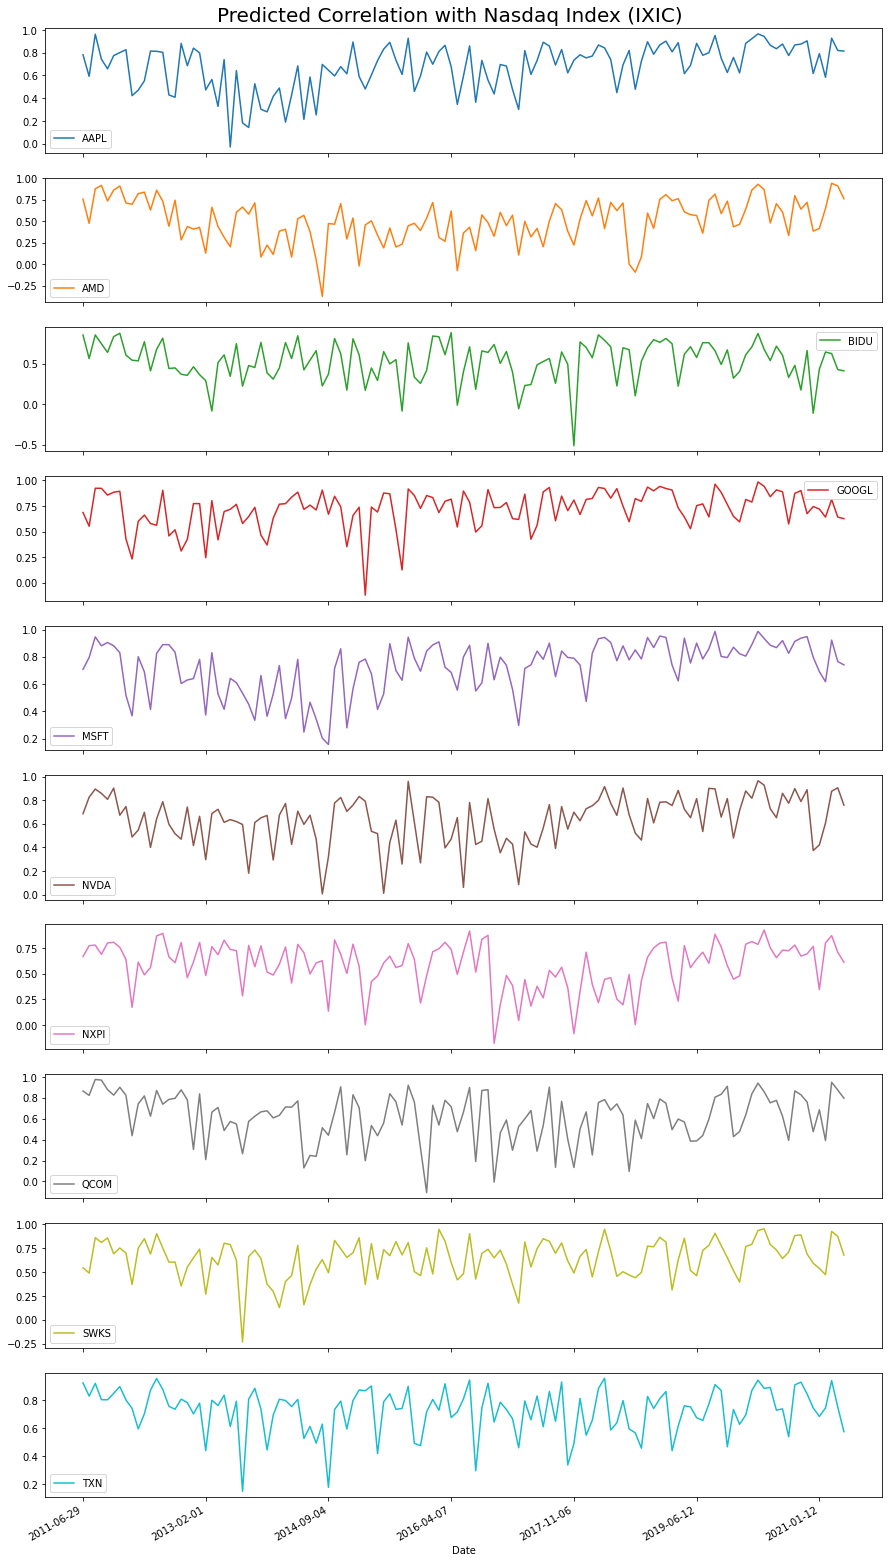

In [8]:
corpred(stock, ixic, 20).plot(figsize = (15,30), subplots=True)
plt.suptitle("Predicted Correlation with Nasdaq Index (IXIC)", fontsize = 20, y = 0.89)

### Histograms of Errors

           APE (Correlation)                                          \
ticker                  AAPL       AMD      BIDU     GOOGL      MSFT   
Date                                                                   
2011-06-29          0.318848  0.588765  0.515494  0.243550  0.109991   
2011-07-28          0.384361  0.456990  0.341589  0.402064  0.159340   
2011-08-25          0.295016  0.043613  0.147507  0.000838  0.073954   
2011-09-23          0.129165  0.246630  0.166215  0.077117  0.026637   
2011-10-21          0.149554  0.147195  0.233274  0.031754  0.027492   
...                      ...       ...       ...       ...       ...   
2020-12-11          0.219784  0.071617  1.262588  0.034062  0.152338   
2021-01-12          0.355260  0.358879  0.328893  0.122344  0.120409   
2021-02-10          0.370494  0.310572  0.030626  0.211867  0.330671   
2021-03-11          0.132487  0.034854  0.463393  0.269500  0.205008   
2021-04-09          0.005902  0.194748  0.038157  0.024052  0.03

(None,
 array([[<AxesSubplot:title={'center':"('AMPE (Correlation)', 'AAPL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Correlation)', 'AMD')"}>,
         <AxesSubplot:title={'center':"('AMPE (Correlation)', 'BIDU')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Correlation)', 'GOOGL')"}>,
         <AxesSubplot:title={'center':"('AMPE (Correlation)', 'MSFT')"}>,
         <AxesSubplot:title={'center':"('AMPE (Correlation)', 'NVDA')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Correlation)', 'NXPI')"}>,
         <AxesSubplot:title={'center':"('AMPE (Correlation)', 'QCOM')"}>,
         <AxesSubplot:title={'center':"('AMPE (Correlation)', 'SWKS')"}>],
        [<AxesSubplot:title={'center':"('AMPE (Correlation)', 'TXN')"}>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

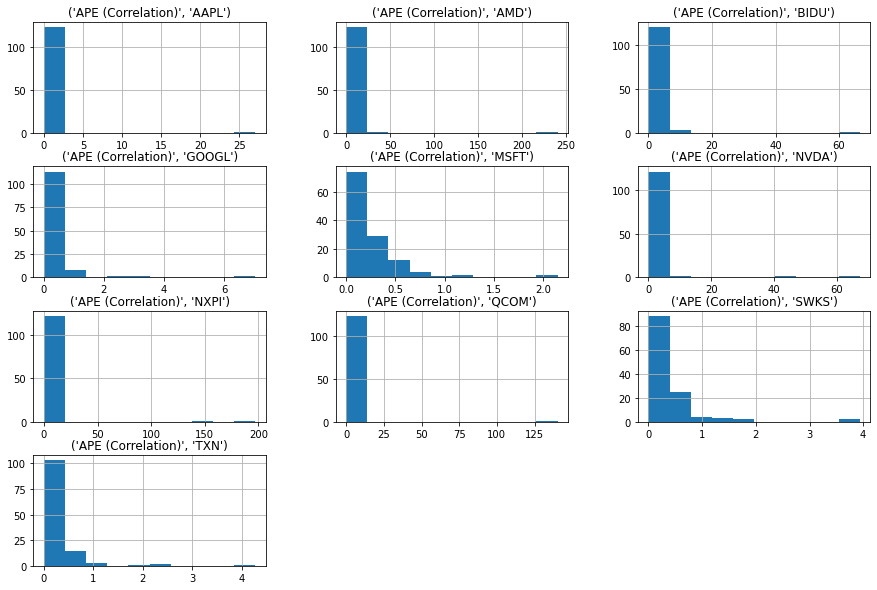

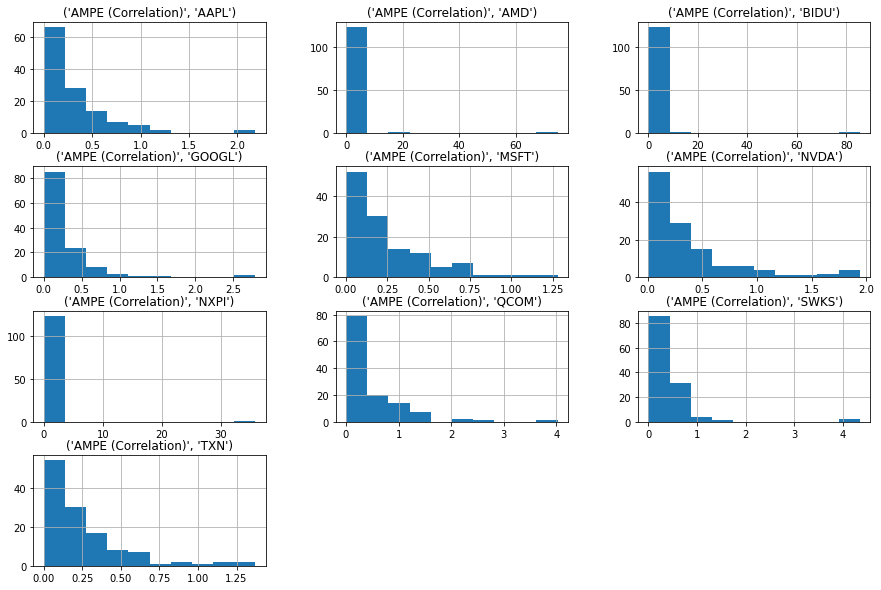

In [9]:
# APE, n=20
plothist_cor(corAPE, stock, ixic, 20)
# AMPE, n=20
plothist_cor(corAMPE, stock, ixic, 20)

### Dot plots of percentage of errors greater than a chosen tail

ticker      AAPL       AMD      BIDU     GOOGL      MSFT      NVDA      NXPI  \
5       0.735060  0.856574  0.838645  0.723108  0.679283  0.794821  0.842629   
10      0.704000  0.852000  0.828000  0.648000  0.636000  0.788000  0.780000   
15      0.704819  0.789157  0.801205  0.710843  0.710843  0.807229  0.813253   
20      0.758065  0.814516  0.838710  0.669355  0.645161  0.774194  0.790323   
25      0.686869  0.848485  0.787879  0.666667  0.646465  0.737374  0.757576   
30      0.719512  0.792683  0.914634  0.646341  0.634146  0.719512  0.768293   
35      0.700000  0.857143  0.800000  0.685714  0.600000  0.700000  0.757143   
40      0.704918  0.819672  0.819672  0.737705  0.639344  0.770492  0.688525   
45      0.685185  0.777778  0.759259  0.666667  0.666667  0.574074  0.685185   
50      0.714286  0.877551  0.857143  0.571429  0.632653  0.632653  0.795918   
55      0.704545  0.818182  0.795455  0.568182  0.568182  0.681818  0.818182   
60      0.575000  0.775000  0.850000  0.

<AxesSubplot:title={'center':'Correlation with Nasdaq, Percentage of error observations greater than tail=0.1, AMPE'}>

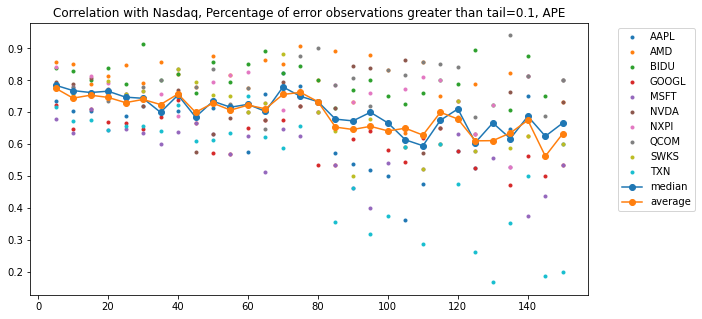

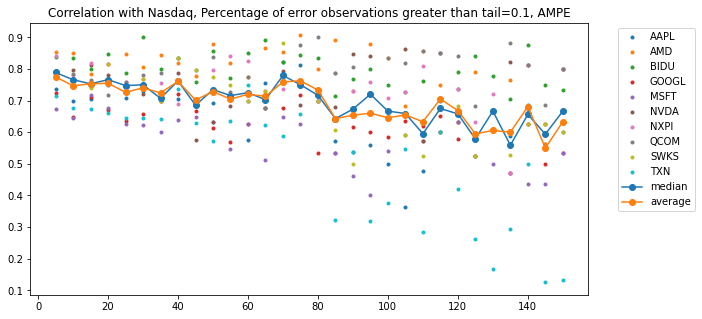

In [10]:
# APE, tail=0.1
plotdot_cor(corAPE, ixic, 5, 150, 5, 0.1)[3]
# AMPE, tail=0.5
plotdot_cor(corAMPE, ixic, 5, 150, 5, 0.1)[3]

### Dot plots of R-Squared

        5         10        15        20        25        30        35   \
0  0.021038  0.073944  0.105885  0.119283  0.206021  0.158709  0.149648   
1  0.005303  0.060196  0.136038  0.169459  0.163796  0.226945  0.111186   
2  0.006872  0.023367  0.037136  0.004051  0.000126  0.002067  0.028095   
3  0.008517  0.005601  0.028165  0.039774  0.054401  0.033417  0.024531   
4  0.040237  0.095181  0.131159  0.205344  0.153376  0.100542  0.190531   
5  0.007920  0.003817  0.006086  0.066605  0.045635  0.193372  0.076116   
6  0.025343  0.088682  0.067222  0.099502  0.150907  0.191704  0.225198   
7  0.019249  0.028434  0.025651  0.016939  0.029021  0.035512  0.035277   
8  0.028951  0.019241  0.016796  0.044007  0.048081  0.017497  0.056373   
9  0.033688  0.017035  0.000035  0.001736  0.000031  0.004864  0.006203   

        40        45        50   ...       105       110       115       120  \
0  0.189375  0.196806  0.290401  ...  0.604155  0.504243  0.372984  0.472953   
1  0.133241  0

(None,
 None,
 None,
 <AxesSubplot:title={'center':'Correlation, R-squared from regression between actual and prediction'}>,
 <AxesSubplot:title={'center':'Correlation, R-squared from regression between actual and prediction'}>,
 <AxesSubplot:title={'center':'Correlation, R-squared from regression between actual and prediction'}>)

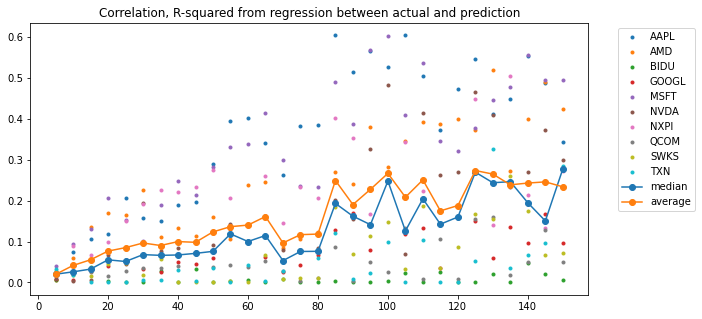

In [11]:
plotr2_cor(ixic, 5, 150, 5)